C:\Users\WinIF Chung\AppData\Roaming\Python\Python312\site-packages\torch\cuda\__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


C3: (1, 512, 100, 100)  C4: (1, 1024, 50, 50)  C5: (1, 2048, 25, 25)
P5: (1, 256, 25, 25)
P4: (1, 256, 50, 50)
P3: (1, 256, 100, 100)


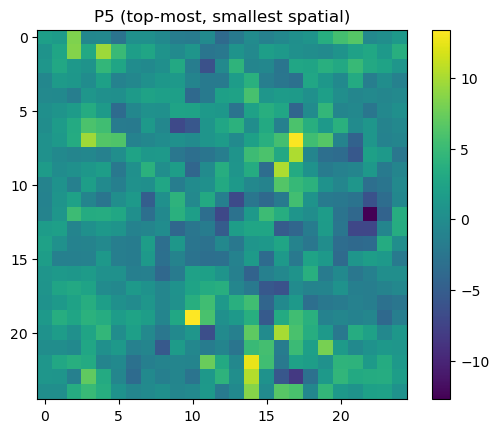

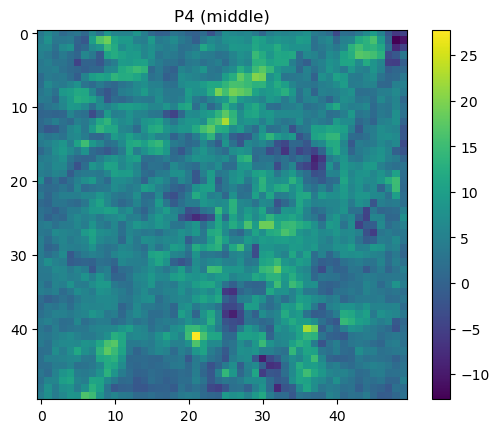

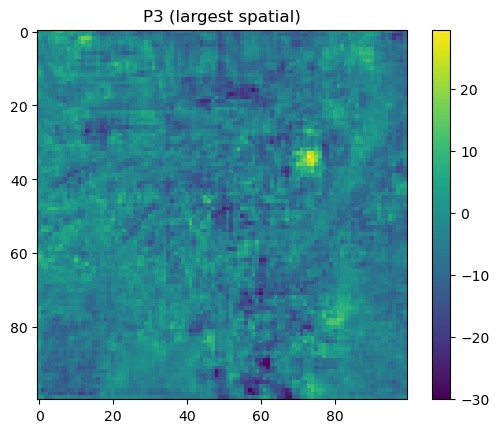

In [1]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import matplotlib.pyplot as plt

# ----- 0) Chuẩn bị ảnh & backbone -----
img_path = "D:/QG_2022/new_data/QG3506.jpg"   # thay đường dẫn của bạn
img = Image.open(img_path).convert("RGB")

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((800, 800)),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                     std=[0.229,0.224,0.225]),
])
x = transform(img).unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)

# Lấy C3/C4/C5 từ ResNet-50
backbone = torchvision.models.resnet50(weights="IMAGENET1K_V2").to(device).eval()
nodes = {"layer2": "C3", "layer3": "C4", "layer4": "C5"}
extractor = create_feature_extractor(backbone, return_nodes=nodes)

with torch.no_grad():
    feats = extractor(x)   # dict: {'C3':T, 'C4':T, 'C5':T}
C3, C4, C5 = feats["C3"], feats["C4"], feats["C5"]
print("C3:", tuple(C3.shape), " C4:", tuple(C4.shape), " C5:", tuple(C5.shape))

for k, v in feats.items():
    image_array = v[0, 10, :, :]
    
    plt.imshow(image_array, cmap='gray') # 'gray' colormap for grayscale images
    plt.colorbar() # Optional: Add a color bar to show intensity mapping
    plt.title("2D Array as Grayscale Image")
    plt.show()

# ----- 1) Định nghĩa FPN tối giản -----
class SimpleFPN(nn.Module):
    """
    Xây P5, P4, P3 từ C5, C4, C3 (top-down):
      P5 = 1x1(C5) -> (smooth 3x3)
      P4 = 1x1(C4) + upsample(P5) -> (smooth 3x3)
      P3 = 1x1(C3) + upsample(P4) -> (smooth 3x3)
    Tất cả đầu ra 256 kênh.
    """
    def __init__(self, c3_channels=512, c4_channels=1024, c5_channels=2048, out_channels=256, use_smooth=True):
        super().__init__()
        # lateral 1x1 convs
        self.lateral_c3 = nn.Conv2d(c3_channels, out_channels, kernel_size=1)
        self.lateral_c4 = nn.Conv2d(c4_channels, out_channels, kernel_size=1)
        self.lateral_c5 = nn.Conv2d(c5_channels, out_channels, kernel_size=1)

        self.use_smooth = use_smooth
        if use_smooth:
            # 3x3 smoothing convs
            self.smooth_p5 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            self.smooth_p4 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            self.smooth_p3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Kế hoạch init nhẹ nhàng
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, C3, C4, C5):
        # lateral projections
        L5 = self.lateral_c5(C5)  # -> 256
        L4 = self.lateral_c4(C4)  # -> 256
        L3 = self.lateral_c3(C3)  # -> 256

        # top-down pathway
        P5 = L5
        P4 = L4 + F.interpolate(P5, size=L4.shape[-2:], mode='nearest')
        P3 = L3 + F.interpolate(P4, size=L3.shape[-2:], mode='nearest')

        if self.use_smooth:
            P5 = self.smooth_p5(P5)
            P4 = self.smooth_p4(P4)
            P3 = self.smooth_p3(P3)

        return P5, P4, P3

# ----- 2) Chạy FPN -----
fpn = SimpleFPN().to(device).eval()
with torch.no_grad():
    P5, P4, P3 = fpn(C3, C4, C5)

print("P5:", tuple(P5.shape))
print("P4:", tuple(P4.shape))
print("P3:", tuple(P3.shape))

# ----- 3) Trực quan 1 kênh (heatmap) để thấy tỉ lệ không gian -----
def show_heatmap(feat, title):
    fmap = feat[0, 0].detach().cpu().numpy()  # [N,C,H,W] -> channel 0
    plt.figure()
    plt.imshow(fmap, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.show()

show_heatmap(P5, "P5 (top-most, smallest spatial)")
show_heatmap(P4, "P4 (middle)")
show_heatmap(P3, "P3 (largest spatial)")
